In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

from dataclasses import dataclass

In [3]:
@dataclass
class BSParams:
    S0: float   # initial Price
    K: float    # strike price
    T: float    # maturity (years)
    r: float    # risk-free rate
    sigma: float # volatility

#Assumed model parameters
model = BSParams(S0=100, K=100, T=1.0, r=0.05, sigma=0.2)

To exercise writing code with reproducibility, I attempt to make use of rng and np.random.default_rng(). However, I am not very comfortable with it, and required aid from ChatGPT 5.2.

In [4]:
#simulate terminal price under risk-neutral geometric brownian motion

def simulate_ST(params: BSParams, n_paths: int, seed=None):
    #create an rng and use it to create the distribution
    rng = np.random.default_rng(seed)
    Z = rng.standard_normal(n_paths)

    #Calculate terminal asset prices ST
    drift = (params.r - 0.5 * params.sigma**2) * params.T
    diff = params.sigma * np.sqrt(params.T) * Z
    ST = params.S0 * np.exp(drift + diff)
    return ST

# returns array of size n_paths

In [5]:
#discounting the payoff
def european_payoff(ST, K, kind="call"):
    if kind == "call":
        return np.maximum(ST - K, 0.0)
    elif kind == "put":
        return np.maximum(K - ST, 0.0)
    else:
        raise ValueError("kind must be 'call' or 'put'")


def disc_factor(params):
    return np.exp(-(params.r) * (params.T))
    
#returns array of size n_paths

In [6]:
#Monte Carlo price + 95% confidence interval (CI)
#Key: MC estimator is sample mean of discounted payoffs. CI uses standard error

def mc_price(params: BSParams, n_paths: int, kind="call", seed=None):
    
    #calculate each discounted payoff
    ST = simulate_ST(params, n_paths, seed=seed)
    payoff = european_payoff(ST, params.K, kind=kind)
    disc_payoff = disc_factor(params) * payoff

    #calcualte V_N.
    price = disc_payoff.mean()
    
    #sample std dev of discounted payoffs
    s = disc_payoff.std(ddof=1)
    se = s / np.sqrt(n_paths)
    ci95 = (price - 1.96 * se, price + 1.96 * se)
    return price, se, ci95

In [7]:
#test above
price, se, ci = mc_price(model, n_paths=200_000, kind="call", seed=None)

price, se, ci

(10.407807059196141,
 0.03276585840019385,
 (10.343585976731761, 10.472028141660521))

In [8]:
#Black-scholes analytically solved value: Formulas from wikepedia!
def norm_cdf(x):
    return 0.5 * (1.0 + math.erf(x / np.sqrt(2.0)))

def black_scholes_price(params: BSParams, kind="call"):
    S0, K, T, r, sigma = params.S0, params.K, params.T, params.r, params.sigma #To make formulas easier to write

    #simply use call and put formulas
    d_pos = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d_neg = d_pos - sigma * np.sqrt(T)
    
    if kind == "call":
        return S0 * norm_cdf(d_pos) - K * np.exp(-r * T) * norm_cdf(d_neg)
    elif kind == "put":
        return K * np.exp(-r * T) * norm_cdf(-d_neg) - S0 * norm_cdf(-d_pos)
    else:
        raise ValueError("kind must be 'call' or 'put'")

In [9]:
#Compare the analytically solved BS value against the MC and its confidence interval

bs = black_scholes_price(model, kind="call")
mc, se, ci = mc_price(model, 200_000, kind="call", seed=None)

print("BS:", bs)
print("MC:", mc)
print("95% CI:", ci)
print("In CI?", ci[0] <= bs <= ci[1]) #CI is random: 95% of the intervals will contain the true BS value

BS: 10.450583572185565
MC: 10.379836806143853
95% CI: (10.315652942313992, 10.444020669973714)
In CI? False


In [35]:
#convergence experiment (error vs N)

def convergence_table(params: BSParams, kind="call", Ns=(1_000, 5_000, 20_000, 100_000, 500_000), seed=123):
    bs = black_scholes_price(params, kind=kind)
    diffs = []
    for N in Ns:
        mc, se, ci = mc_price(params, N, kind=kind, seed=seed)
        diffs.append(mc - bs)
    return Ns, diffs

Ns, diffs = convergence_table(model, kind="call")
Ns[:2], diffs[:2]

((1000, 5000), [0.26562017106015823, 0.08708371648256197])

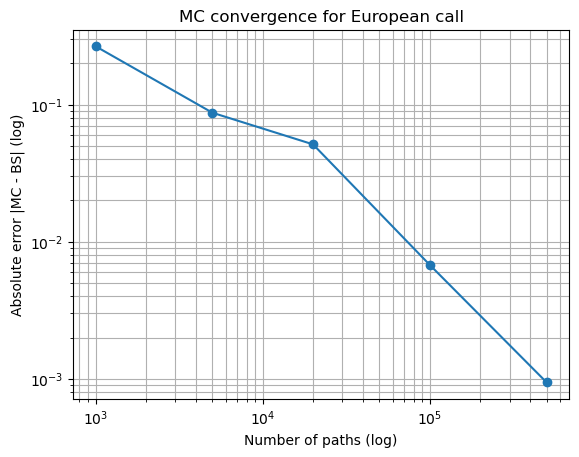

In [36]:
#plot
abs_err = [abs(d) for d in diffs]

plt.figure()
plt.loglog(Ns, abs_err, marker='o')
plt.xlabel("Number of paths (log)")
plt.ylabel("Absolute error |MC - BS| (log)")
plt.title("MC convergence for European call")
plt.grid(True, which="both")

plt.savefig("mc_convergence.png", dpi=300, bbox_inches="tight")
plt.show()

In [16]:
#Variance reduction (antithetic variates)
def mc_price_antithetic(params: BSParams, n_paths: int, kind="call", seed=None):
    #Split the number of inputs evenly
    if n_paths % 2 == 1:
        n_paths += 1
    half = n_paths // 2

    #generate sample
    rng = np.random.default_rng(seed)
    Z = rng.standard_normal(half)
    #create anarray of every entry and its negative
    Z_full = np.concatenate([Z, -Z])

    #use formulas
    drift = (params.r - 0.5 * params.sigma**2) * params.T
    diff = params.sigma * np.sqrt(params.T) * Z_full
    ST = params.S0 * np.exp(drift + diff)

    #discounted payoffs
    payoff = european_payoff(ST, params.K, kind=kind)
    disc = disc_factor(params) * payoff

    #results
    price = disc.mean()
    s = disc.std(ddof=1)
    se = s / np.sqrt(n_paths)
    ci95 = (price - 1.96 * se, price + 1.96 * se)
    return price, se, ci95


In [18]:
N = 100_000

#Compare the methods with the same rng seed
mc1, se1, ci1 = mc_price(model, N, kind="call", seed=42)
mc2, se2, ci2 = mc_price_antithetic(model, N, kind="call", seed=42)
print("Standard SE:", se1)
print("Antithetic SE:", se2)


Standard SE: 0.046769902520818175
Antithetic SE: 0.04672118831220032
